# Collect RL Results
Summarize the different RL runs we have completed and assess the best ones

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Find RL Runs
They are in the root directory of this project

In [2]:
dirs = list(filter(os.path.isdir, glob(os.path.join('..', '..', 'rl_tests', '*'))))
print(f'Found {len(dirs)} run directories')

Found 30 run directories


## Create Utility Functions
Functions for reading in results from a run and putting them in a summary that is easy to sort through

In [3]:
def summarize_run(path: str) -> dict:
    """Summarize the performance of a certain run
    
    Args:
        path (str): Path to the ML run
    Returns:
        (dict) Run summary
    """
    
    # First, load in the configuratoin
    with open(os.path.join(path, 'config.json')) as fp:
        output = json.load(fp)
    output['path'] = path
        
    # Load in the name of the system and some other performance details
    perf_path = os.path.join(path, 'performance.json')
    if os.path.isfile(perf_path):
        with open(perf_path) as fp:
            perf = json.load(fp)
            for k in ['hostname', 'runtime']:
                output[k] = perf[k]
        output['complete'] = True
    else:
        output['complete'] = False
            
    # Assess the run data
    try:
        mols = pd.read_csv(os.path.join(path, 'molecules.csv'))
    except:
        return output
    if not output['maximize']:
        mols['reward'] = -1 * mols['reward']
    output['episodes_completed'] = mols['episode'].max() + 1
    output['rewards_computed'] = len(mols)
    output['unique_molecules'] = len(set(mols['smiles']))
    output['unique_fraction'] = output['unique_molecules'] / len(mols)
    output['best_found'] = mols['ic50'].max()
    output['pIC50_above_8'] = len(set(mols[mols['ic50'] > 8]['smiles']))
        
    return output

In [4]:
results = pd.DataFrame(summarize_run(x) for x in dirs)

In [5]:
columns_to_disp = ['epsilon', 'max_steps', 'episodes', 'episodes_completed', 'path',
                   'no_backtrack', 'gamma', 'reward', 'epsilon_decay', 'q_update_freq', 'best_found', 'pIC50_above_8']
results.query('reward=="ic50"').sort_values('best_found', ascending=False).head(6)[columns_to_disp]

,epsilon,max_steps,episodes,episodes_completed,path,no_backtrack,gamma,reward,epsilon_decay,q_update_freq,best_found,pIC50_above_8
22,1.0,80,5000,2112.0,../../rl_tests/2020-06-11T18.21.14.076564_ic50,False,0.9,ic50,0.9950,10,10.985413,26870.0
11,1.0,80,5000,5000.0,../../rl_tests/ic50_2020-06-12T10.51.25.454421,False,0.9,ic50,0.9950,10,10.766213,49548.0
15,1.0,80,5000,5000.0,../../rl_tests/ic50_2020-06-15T06.48.39.315957,False,0.9,ic50,0.9995,10,10.610582,50213.0
20,1.0,40,5000,5000.0,../../rl_tests/ic50_2020-06-14T09.15.46.720226,False,0.9,ic50,0.9995,10,10.565168,20850.0
23,1.0,40,5000,5000.0,../../rl_tests/2020-06-11T17.26.22.623448_ic50,False,0.9,ic50,0.9950,10,10.340915,16423.0
28,1.0,40,5000,5000.0,../../rl_tests/ic50_2020-06-12T10.50.21.000992,False,0.0,ic50,0.9950,10,9.734042,663.0


In [6]:
results.to_json('runs.json')

## Compare the Performance for the "Best One"
Get the run that finds the best molecule and compare it to brute force searching

Load in the random search data

In [7]:
random_search = pd.read_csv(os.path.join('..', 'baseline', 'random_search_perf_pIC50_mpnn.csv'))

Load in the best values

In [8]:
with open(os.path.join('..', 'baseline', 'top_pIC50_mpnn.json')) as fp:
    best_e15 = json.load(fp)

Find the best run

In [9]:
best_ic50 = results.query('reward=="MO" and max_steps==40').sort_values('pIC50_above_8', ascending=False).head(2)
best_ic50[columns_to_disp]

,epsilon,max_steps,episodes,episodes_completed,path,no_backtrack,gamma,reward,epsilon_decay,q_update_freq,best_found,pIC50_above_8
13,1.0,40,5000,5000.0,../../rl_tests/2020-06-11T17.29.05.994330_MO,False,0.9,MO,0.9995,10,10.827705,15932.0
3,1.0,40,5000,5000.0,../../rl_tests/MO_2020-06-14T09.15.46.665975,False,0.9,MO,0.9995,10,10.758287,14953.0


In [10]:
best_run = best_ic50['path'].iloc[0]
print(f'Chose {best_run}')

Chose ../../rl_tests/2020-06-11T17.29.05.994330_MO


In [11]:
best_run

'../../rl_tests/2020-06-11T17.29.05.994330_MO'

Load in the trajectory for that run

In [12]:
mols = pd.read_csv(os.path.join(best_run, 'molecules.csv'))

Text(0, 0.5, 'Best pIC50')

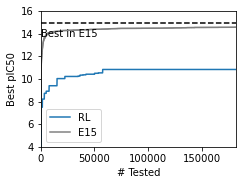

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(mols['ic50'].cummax(), label='RL')
ax.plot(random_search['best_mean'], label='E15', color='gray')
ax.fill_between(range(len(random_search)), 
                random_search['best_mean'] + random_search['best_sem'], 
                random_search['best_mean'] - random_search['best_sem'],
                alpha=0.5, color='gray')

ax.set_xlim(0, len(mols))
ax.set_ylim(4, 16)

ax.plot(ax.get_xlim(), [best_e15['best']]*2, 'k--')
ax.text(100, best_e15['best'] - 0.5, 'Best in E15', ha='left', va='top')

ax.legend()

ax.set_xlabel('# Tested')
ax.set_ylabel('Best pIC50')

Plot the number with pIC50>8 found

In [14]:
mols['unique'] = False
mols.loc[mols.drop_duplicates('smiles', keep='first').index, 'unique'] = True

In [15]:
mols['unique'].value_counts()

False    115843
True      66605
Name: unique, dtype: int64

Text(0, 0.5, 'Unique Mols with pIC50 > 8')

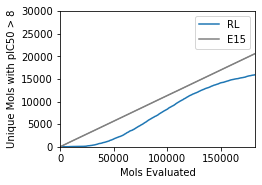

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(np.logical_and(mols['ic50'] > 8, mols['unique']).cumsum(), label='RL')
ax.plot(random_search['past_thresh_mean'], label='E15', color='gray')
ax.fill_between(range(len(random_search)), 
                random_search['past_thresh_mean'] + random_search['past_thresh_sem'], 
                random_search['past_thresh_mean'] - random_search['past_thresh_sem'],
                alpha=0.5, color='gray')

ax.set_xlim(0, len(mols))
ax.set_ylim(0, 30000)

ax.legend()

ax.set_xlabel('Mols Evaluated')
ax.set_ylabel('Unique Mols with pIC50 > 8')

Plot the Pareto Surface

In [17]:
mols.columns

Index(['episode', 'step', 'epsilon', 'smiles', 'reward', 'q', 'random', 'loss',
       'logP', 'ic50', 'QED', 'SA', 'cycles', 'unique'],
      dtype='object')

(8.0, 11.0)

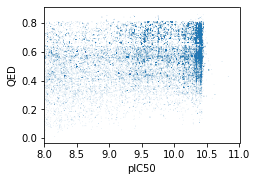

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(mols['ic50'], mols['QED'], alpha=0.2, s=0.5, edgecolor='none')

ax.set_ylabel('QED')
ax.set_xlabel('pIC50')
ax.set_xlim(8, 11)

*Finding*: There are generally clustered in the "low QED" but "high pIC50" region

## Get the Runs for the Paper
Get all of the runs with the same settings

The "paper standard" settings

In [19]:
settings = {
    "epsilon": 1.0,
    "epsilon_decay": 0.9995,
    "max_steps": 40,
    "episodes": 5000,
    "q_update_freq": 10,
    "hidden_layers": [1024, 512, 128, 32],
    "gamma": 0.9,
    "fingerprint_size": 2048,
    "batch_size": 32,
    "no_backtrack": False
}

Filter down to the runs we want

In [20]:
def save_records(settings: dict, out_directory: str): 
    """Save the best runs for a certain setting for all reward functions
    
    Args:
        settings (dict): Settigns for the runs
        out_directory (str): Output directory
    Returns:
        (DataFrame) Matched runs
    """
    
    # Filter down to the desired settings
    prod_runs = results.copy()
    for crit, value in settings.items():
        prod_runs = prod_runs[~prod_runs[crit].isnull()]
        prod_runs = prod_runs[prod_runs[crit].apply(json.dumps) == json.dumps(value)]

    # Get one run per reward function
    prod_runs.sort_values('episodes_completed', ascending=False, inplace=True)
    prod_runs.drop_duplicates('reward', inplace=True)

    # Make a symbolic link to each directory
    os.makedirs(out_directory, exist_ok=True)
    for i, row in prod_runs.iterrows():
        if not row['complete']:
            print(f'Warning: {row["reward"]} is not done')
        ref_path = os.path.relpath(row['path'], out_directory)
        link_path = os.path.join(out_directory, row['reward'])
        if os.path.exists(link_path):
            os.unlink(link_path)
        os.symlink(ref_path, link_path)
    return prod_runs.sort_values('reward')

In [21]:
save_records(settings, 'reference-runs')[columns_to_disp]

,epsilon,max_steps,episodes,episodes_completed,path,no_backtrack,gamma,reward,epsilon_decay,q_update_freq,best_found,pIC50_above_8
3,1.0,40,5000,5000.0,../../rl_tests/MO_2020-06-14T09.15.46.665975,False,0.9,MO,0.9995,10,10.758287,14953.0
8,1.0,40,5000,5000.0,../../rl_tests/QED_2020-06-15T18.38.19.201799,False,0.9,QED,0.9995,10,10.502693,780.0
20,1.0,40,5000,5000.0,../../rl_tests/ic50_2020-06-14T09.15.46.720226,False,0.9,ic50,0.9995,10,10.565168,20850.0
9,1.0,40,5000,5000.0,../../rl_tests/logP_2020-06-14T09.15.46.495174,False,0.9,logP,0.9995,10,10.897053,3453.0


Save the "slow" runs where we made &epsilon; decay at a faster rate

In [22]:
greedy = settings.copy()
greedy['epsilon_decay'] = 0.995

In [23]:
save_records(greedy, 'greedy-runs')[columns_to_disp]

,epsilon,max_steps,episodes,episodes_completed,path,no_backtrack,gamma,reward,epsilon_decay,q_update_freq,best_found,pIC50_above_8
4,1.0,40,5000,5000.0,../../rl_tests/2020-06-11T17.26.22.502145_MO,False,0.9,MO,0.995,10,8.336426,9.0
23,1.0,40,5000,5000.0,../../rl_tests/2020-06-11T17.26.22.623448_ic50,False,0.9,ic50,0.995,10,10.340915,16423.0
24,1.0,40,5000,5000.0,../../rl_tests/2020-06-11T17.26.22.433594_logP,False,0.9,logP,0.995,10,10.308691,1595.0


Save the "myopic" calcualtions, where we set the Bellmann look-ahead to 0

In [24]:
myopic = greedy.copy()
myopic['gamma'] = 0.

In [25]:
save_records(myopic, 'myopic-runs')[columns_to_disp]

,epsilon,max_steps,episodes,episodes_completed,path,no_backtrack,gamma,reward,epsilon_decay,q_update_freq,best_found,pIC50_above_8
27,1.0,40,5000,5000.0,../../rl_tests/MO_2020-06-12T10.50.21.518834,False,0.0,MO,0.995,10,11.246351,3764.0
28,1.0,40,5000,5000.0,../../rl_tests/ic50_2020-06-12T10.50.21.000992,False,0.0,ic50,0.995,10,9.734042,663.0
17,1.0,40,5000,5000.0,../../rl_tests/logP_2020-06-12T10.50.21.135161,False,0.0,logP,0.995,10,10.421689,1841.0
